<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel-MilepostAtTime-MASTER-60min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
auth.authenticate_user()


     |████████████████████████████████| 719 kB 24.8 MB/s 
     |████████████████████████████████| 4.4 MB 47.0 MB/s 
     |████████████████████████████████| 1.2 MB 60.0 MB/s 
     |████████████████████████████████| 362 kB 59.6 MB/s 
     |████████████████████████████████| 212 kB 71.2 MB/s 
     |████████████████████████████████| 1.1 MB 36.5 MB/s 
     |████████████████████████████████| 140 kB 59.3 MB/s 
     |████████████████████████████████| 101 kB 9.1 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 127 kB 56.8 MB/s 
     |████████████████████████████████| 271 kB 59.8 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 144 kB 52.1 MB/s 
     |████████████████████████████████| 6.6 MB 41.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10

In [2]:
#filename = "train-data_all-train-events.zip"
#filename = "train-data-2022062020220626.zip"

#events-20-min includes reports for all trains in the a 2 week window reporting at most every 20 minutes 
#filename = "train-events-20-min.zip"

#Train reportings 15 minutes apart - everything we have collected
filename = "train-data-master.zip"

# miles answers the question "what spped will this train be moving in X miles (technically at milepost +/-X)"
#measurement = { 'unit' : 'miles', 'size' : 1.0 }

# minutes answers the question : what speed will this train be moving in X Minutes
#measurement = { 'unit' : 'minutes', 'size' : 90.0 }

#dep_var = 'nextSpeed'

# milepost answers the question "What milepost will this train be at in X Minutes"
measurement = { 'unit' : 'milepost', 'size' : 60.0 }
dep_var = 'nextValue'

#Determines the portion of data to train versus validate
dataCutpoint = .80

In [3]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-data-master.zip...
/ [1 files][236.7 MiB/236.7 MiB]                                                
Operation completed over 1 objects/236.7 MiB.                                    


In [4]:
trains = {}
i = 1
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      print(i, " ", datetime.now().strftime("%H:%M:%S"))
                            

1000   14:27:00
2000   14:27:11
3000   14:27:22
4000   14:27:27
5000   14:27:35
6000   14:27:41
7000   14:27:46
8000   14:27:52
9000   14:27:56
10000   14:28:01
11000   14:28:07
12000   14:28:12
13000   14:28:17
14000   14:28:21
15000   14:28:27
16000   14:28:33
17000   14:28:37
18000   14:28:45
19000   14:28:50
20000   14:28:56
21000   14:29:00
22000   14:29:05
23000   14:29:12
24000   14:29:16
25000   14:29:23
26000   14:29:27
27000   14:29:32
28000   14:29:39
29000   14:29:44
30000   14:29:48
31000   14:29:56
32000   14:30:01
33000   14:30:05
34000   14:30:09
35000   14:30:18
36000   14:30:22
37000   14:30:26
38000   14:30:30


In [5]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [6]:
del trains

In [7]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38085 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            38085 non-null  object 
 1   positionHistoryList                                            38085 non-null  object 
 2   locomotiveList                                                 38085 non-null  object 
 3   subdivisionList                                                38085 non-null  object 
 4   trainEstimatedPositionList                                     38085 non-null  object 
 5   trainActualPositionList                                        38085 non-null  object 
 6   trainId.trainSCAC                                              38041 non-null  object 
 7   trainId.trainSection                                          

# Create a learning set to modify

In [8]:
dfTrainsLearn = dfTrainsAll

Clear the nan values and replace with max values.

In [9]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)

Determine if the train is moving milepost Increasing or decreasing.

In [10]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

Make all speeds positive

In [11]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

Speed Distribution:


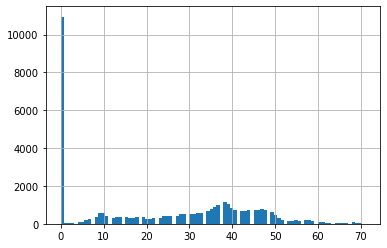

In [12]:
print("Speed Distribution:")
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

Replace the NaN values in AOTU with zeros

In [13]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

Categorize the applicable variables

In [14]:
def categorize(aDataFrame, columnName, defaultReplacement):
  aDataFrame[columnName] = aDataFrame[columnName].fillna(value=defaultReplacement)
  categories = aDataFrame[columnName].unique()
  print(aDataFrame[columnName].unique())
  aDataFrame[columnName] = aDataFrame[columnName].astype('category')
  aDataFrame[columnName] = aDataFrame[columnName].cat.set_categories(categories)
  return aDataFrame

In [15]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn = categorize(dfTrainsLearn, 'symbolType', "X")
dfTrainsLearn = categorize(dfTrainsLearn, 'lastReportedPosition.milepostLocation.trackName', "UNKNOWN")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSCAC',"UNK")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSection', ' ')
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.priorityCode', 0)  # may want to order these
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.categoryCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.authorityRangeCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.ownershipCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.tenantCarrier', "0")
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.eventCode', 0)
 

['Q' 'A' 'M' 'U' 'G' 'I' 'E' 'C' 'Y' 'L' 'W' 'Z' 'S' 'O' 'H' 'R' 'P']
['EAST MAIN' 'WEST MAIN' 'TO_S_UP_MAINLINE' 'S_VIDOR' 'MAIN CHAISON YARD' 'MAIN' 'TO_N_EAST MAIN' 'TO_S_VIDOR' 'TO_S_CS JUNCTION' 'TO_N_HELME' 'S_HELME' 'WALL ST MAIN' 'JEFFERSON REFINERY'
 'NEW LACY TRACK' 'TO_N_LUCAS' 'S_LUCAS' 'S_MAURICEVILLE' 'TO_S_WALL ST MAIN' 'TO_N_JEFFERSON RF' 'MT 1' 'MT 2' 'TO_N_MAURICEVILLE' 'TO_N_VIDOR' 'EASTXO' 'N SIDING' 'WALL ST CROSSOVER' 'WESTXO'
 'YD LD' 'KCS UP PORT CONNECT' 'TO_S_KCS UP PRT CONN' '136' 'XO' 'TO_S_NEW LACY TRACK' 'TO_N_CHAISON MAIN' 'TO_S_LUCAS' '806' '405' 'S_LEESVILLE' 'S_NEAME' 'S_CONVERSE' 'S_FISHER' 'CHAISON MAIN'
 'S_ANACOCO' 'S_STARKS' 'TO_N_SRN CONNECTION' 'S_SINGER' '113']
['UP' 'UNK']
['2' '' '3' '5' '4']
[2. 1. 0. 4. 3.]
[12. 14.  0. 18.  8. 10. 15.  4. 20. 11.  2. 19. 17. 13.  9. 16.]
[2. 0. 1. 3.]
[3. 0. 2.]
['BNSF' 'AMTK' 0.0 'KCS' '']
[0.]


Replace unknown max speeds with 88 miles per hour (to make them recognizable)

In [16]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[88. 50. 60. 70. 40. 45.  0. 30. 79.]


Flatten out the work locations (we may want to change this for the NN algorithm)

In [17]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [18]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [19]:
dfTrainsLearn['workLocations'].unique()

array([None, '202.20', '258.40,202.20', '225.10', '202.20,258.40,321.50', '314.52,202.20', '321.50,202.20', '231.80,225.10', '214.50', '225.10,202.20', '202.20,258.40', '202.20,219.70',
       '219.70,202.20', '202.20,214.50,225.10,290.80,304.10', '202.20,258.40,225.10', '202.20,219.90,225.10', '202.20,257.60', '250.50,202.20', '268.40,202.20', '258.40,207.60,202.20',
       '207.60,202.20', '241.00,202.20', '258.40,219.70,202.20', '202.20,314.52', '202.92,202.20', '214.50,225.10,290.80,304.10,202.20', '290.80,258.40,231.80,202.20', '202.20,290.80',
       '202.20,299.75', '314.52,225.10,202.20', '202.20,219.70,277.50', '202.20,293.10', '202.20,304.10', '321.50,314.52,202.20', '202.20,240.90', '202.20,265.30', '265.30,202.20', '202.20,286.40',
       '240.90,207.60,202.20', '250.50,245.90,202.20', '219.70', '202.20,312.80', '321.50,240.90,202.20', '240.90,202.20', '202.20,207.60', '202.20,225.10', '326.20,214.50', '214.50,202.20',
       '240.90,214.50,202.20', '278.10,258.40,202.20', 

determine the locomotive count from the locomotive list.  We can make this more clever later, but for now this seems the most sensible shortcut

In [20]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

Convert the list of actual reportings into a dataframe.

In [21]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [22]:
def showTrain(idx):
  print(dfTrainsLearn.iloc[idx]['ptcLeadLocomotiveId'])
  print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])


You can peer into the incoming data here:

In [23]:
idx = 201
showTrain(idx)
dfTrainsLearnActuals.iloc[idx]

KCS4863
MWARNJ


,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-05-28T07:37:26Z,0,106,S_VIDOR,762.73100
1,2022-05-28T07:39:26Z,0,106,S_VIDOR,762.73100
2,2022-05-28T07:41:26Z,0,106,S_VIDOR,762.73060
3,2022-05-28T07:43:26Z,0,106,S_VIDOR,762.73060
4,2022-05-28T07:47:26Z,0,106,S_VIDOR,762.73060
...,...,...,...,...,...
25,2022-05-28T08:35:26Z,11,106,MAIN,764.03827
26,2022-05-28T08:37:26Z,13,106,MAIN,764.46796
27,2022-05-28T08:39:26Z,14,106,MAIN,764.90643
28,2022-05-28T08:41:26Z,15,106,MAIN-WEST MAIN,765.40290


In [24]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,766.9251,[]
0,766.4507,[]
0,766.9269,[]
0,766.9267,[]
0,764.8708,[]
...,...,...
0,766.3489,[]
0,761.0639,[]
0,766.9314,[]
0,762.7375,[]


Renumber the list

In [25]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

# Determine NextValue
This will be the value we are attempting to learn

In [26]:
def findNextTime(trainsEntry, actualsEntry, timeInMinutes):
  #print(actualsEntry.iloc[4]['speedMPH'], " - ",trainsEntry['lastReportedPosition.speedMPH'] )
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return (abs(actualsEntry.iloc[idx]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
  return None

In [27]:
def findNextMilepost(trainsEntry, actualsEntry, distance):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost + distance]
  if (len(value) > 0) :
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].min()]
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost - distance]
  if (len(value) > 0):
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].max()]
  return []

In [28]:
def findNextMilepostAtTime(trainsEntry, actualsEntry, timeInMinutes):
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return actualsEntry.iloc[idx]['milepostLocation.milepost.milepostNumber']
  return None

In [29]:
def findNextSpeed(trainsEntry, actualsEntry):
  if (measurement.get('unit') == 'miles'):
    nextActual = findNextMilepost(trainsEntry, actualsEntry, measurement.get('size'))
    if (nextActual != None and len(nextActual) > 0):
      amt = (abs(nextActual.iloc[0]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
      return amt;
  elif (measurement.get('unit') == 'minutes'):
    return findNextTime(trainsEntry, actualsEntry, measurement.get('size'))
  elif (measurement.get('unit') == 'milepost'):
    return findNextMilepostAtTime(trainsEntry, actualsEntry, measurement.get('size'))
  else:
    raise Exception('unknown measurement', measurement.get('unit'))    
  return None

You can peer into the mechanics of a lookup here:

In [30]:
idx = 3291
showTrain(idx)
print("Reported speed: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
print("Reported MP: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])
print("Reported Time: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.positionTime'])

nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 1)
print("Next Speed at MP:",nextActual)
nextActual = findNextTime(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 10)
print("Next Speed at 10 Min:",nextActual)
nextActual = findNextMilepostAtTime(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 10)
print("Milepost in 10 Min:",nextActual)

print("actual Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx]))
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT, 1)
  print(nextBeop)
  type(dfTrainsBeop.iloc[idx]['trainEstimatedPositionList'])
  print("beop Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], beopDT))

BNSF5241
MWARNJ
Reported speed:  0
Reported MP:  762.7356
Reported Time:  2022-06-09T21:29:07Z
Next Speed at MP:             positionTime  speedMPH  milepostLocation.subdivisionId  \
28  2022-06-09T22:27:07Z        18                             106   

   milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
28                       MAIN                                  764.0808  
Next Speed at 10 Min: 0
Milepost in 10 Min: 762.7377
actual Value:  765.254


Run the calulations.  This will take a moment.

In [31]:
dfTrainsLearn['nextValue'] = np.NaN
dfTrainsLearn['beopValue'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextValue = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextValue != None):
    dfTrainsLearn.at[i,'nextValue'] = nextValue
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      if (measurement.get('unit') == 'miles'):
        nextBeop = findNextMilepost(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'minutes'):
        nextBeop = findNextTime(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'milepost'):
        nextBeop = findNextMilepostAtTime(trainsEntry, beopDT, measurement.get('size'))
      if (nextBeop != None):
        dfTrainsLearn.at[i,'beopValue'] = nextBeop
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000


In [32]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['nextValue'])
dfTrainsLearn['nextValue'].unique()

array([762.7347 , 764.5085 , 762.7287 , ..., 762.82874, 766.57025, 759.2366 ])

NextValue values histogram:


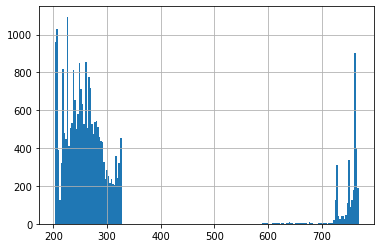

In [33]:
print("NextValue values histogram:")
dfTrainsLearn['nextValue'].hist(bins=200)

In [34]:
dfTrainsLearn['beopValue'].unique()

array([     nan, 765.6878, 772.1762, ..., 787.0846, 798.9698, 807.265 ])

physics predictions histogram:


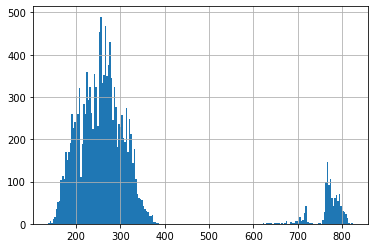

In [35]:
print("physics predictions histogram:")
dfTrainsLearn['beopValue'].hist(bins=200)

In [36]:
dfTrainsNextBeop = dfTrainsLearn['beopValue']

Drop some values we are not using at the moment, not needed.

Note, this will disable above computations unless you resume at "Create a learning set"

In [37]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'beopValue',
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

Burst dates into subcolumns that might prove useful

In [38]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
38,KCS4844,UP,,UBTRNJ,...,False,False,False,1.649828e+09
39,KCS4844,UP,,UBTRNJ,...,False,False,False,1.649829e+09
40,KCS4844,UP,,UBTRNJ,...,False,False,False,1.649830e+09
59,KCS4845,UP,2,MWARNJ,...,False,False,False,1.655760e+09
60,KCS4845,UP,2,MWARNJ,...,False,False,False,1.655761e+09
...,...,...,...,...,...,...,...,...,...
38073,CN2983,UP,,MLIHO,...,False,False,False,1.657146e+09
38074,CN2983,UP,,MLIHO,...,False,False,False,1.657147e+09
38075,CN2983,UP,,MLIHO,...,False,False,False,1.657148e+09
38076,CN2983,UP,,MLIHO,...,False,False,False,1.657149e+09


In [39]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[10])

(25675, 47)
(38085,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25675 entries, 38 to 38077
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            25675 non-null  object        
 1   trainId.trainSCAC                                              25675 non-null  category      
 2   trainId.trainSection                                           25675 non-null  category      
 3   trainId.trainSymbol                                            25675 non-null  object        
 4   trainId.trainDate                                              25675 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  25675 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            25675 non

# Use Decision Tree to predict next speed

In [40]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

Breakdown the data by day of year - we will train with older data and then test the model with newer values.
Note: this simple logic will fail at the begining of a new year!

In [41]:
dateValues = dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count()
print(dateValues)

lastReportedPosition.positionTimeDayofyear
90      51
91     217
92     201
93     227
94     134
      ... 
183    321
184    235
185    222
186    246
187    434
Name: lastReportedPosition.positionTimeDayofyear, Length: 97, dtype: int64


In [98]:
print("We will partition this set at day of year:", dateValues.index[math.trunc(dateValues.size * dataCutpoint)])

We will partition this set at day of year: 167


In [99]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] <= dateValues.index[math.trunc(dateValues.size * dataCutpoint)] )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [100]:
#dep_var = 'nextSpeed'

In [101]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [102]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [103]:
len(to.train),len(to.valid)

(20726, 4949)

In [104]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.eventCode,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextValue
38,KCS4844,UP,,UBTRNJ,2022-04-12,106,S_VIDOR,4.0,18.0,2.0,3.0,0.0,True,U,#na#,2022,False,False,False,False,False,False,0,762.729492,61340000.0,213580.0,4160000.0,8780.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,762,0,4,15,13,2,103,1.649828e+09,762.734680
39,KCS4844,UP,,UBTRNJ,2022-04-12,106,S_VIDOR,4.0,18.0,2.0,3.0,0.0,True,U,#na#,2022,False,False,False,False,False,False,0,762.733887,61340000.0,213580.0,4160000.0,8780.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,762,0,4,15,13,2,103,1.649829e+09,762.734680
40,KCS4844,UP,,UBTRNJ,2022-04-12,106,S_VIDOR,4.0,18.0,2.0,3.0,0.0,True,U,#na#,2022,False,False,False,False,False,False,0,762.734497,61340000.0,213580.0,4160000.0,8780.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,762,0,4,15,13,2,103,1.649830e+09,764.508484
71,KCS4849,UP,,GWARNJ,2022-04-05,106,S_VIDOR,4.0,8.0,2.0,3.0,0.0,True,G,#na#,2022,False,False,False,False,False,False,0,762.732483,267960000.0,658760.0,8360000.0,17560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,762,0,4,14,5,1,95,1.649192e+09,762.735596
72,KCS4849,UP,,GWARNJ,2022-04-05,106,S_VIDOR,4.0,8.0,2.0,3.0,0.0,True,G,#na#,2022,False,False,False,False,False,False,0,762.734680,267960000.0,658760.0,8360000.0,17560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,762,0,4,14,5,1,95,1.649193e+09,762.735779
73,KCS4849,UP,,GWARNJ,2022-04-05,106,S_VIDOR,4.0,8.0,2.0,3.0,0.0,True,G,#na#,2022,False,False,False,False,False,False,0,762.735779,267960000.0,658760.0,8360000.0,17560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,762,0,4,14,5,1,95,1.649194e+09,765.063049
81,AMTK182,UP,,AMT1,2022-04-05,106,TO_S_UP_MAINLINE,1.0,14.0,2.0,3.0,0.0,True,A,#na#,2022,False,False,False,False,False,False,10,764.870605,0.0,0.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,4,14,6,2,96,1.649287e+09,766.110474
99,AMTK204,UP,,AMT1,2022-05-24,106,TO_S_UP_MAINLINE,1.0,14.0,2.0,3.0,0.0,True,A,#na#,2022,False,False,False,False,False,False,10,764.869080,3280000.0,60960.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,5,21,25,2,145,1.653514e+09,766.127686
115,KCS4851,UP,,MWARNJ,2022-04-06,106,MAIN,4.0,12.0,2.0,3.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,762.734314,181220000.0,1104910.0,8160000.0,17690.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,762,0,4,14,7,3,97,1.649355e+09,762.816711
131,KCS4854,UP,,GWARNJ,2022-04-04,106,MAIN,4.0,8.0,2.0,3.0,0.0,True,G,#na#,2022,False,False,False,False,False,False,0,762.745605,0.0,0.0,8480000

In [105]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [106]:
to = fastai.load_pickle('/tmp/to.pkl')

In [107]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [108]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

Here is a sample of a Decision Tree with just 16 nodes:

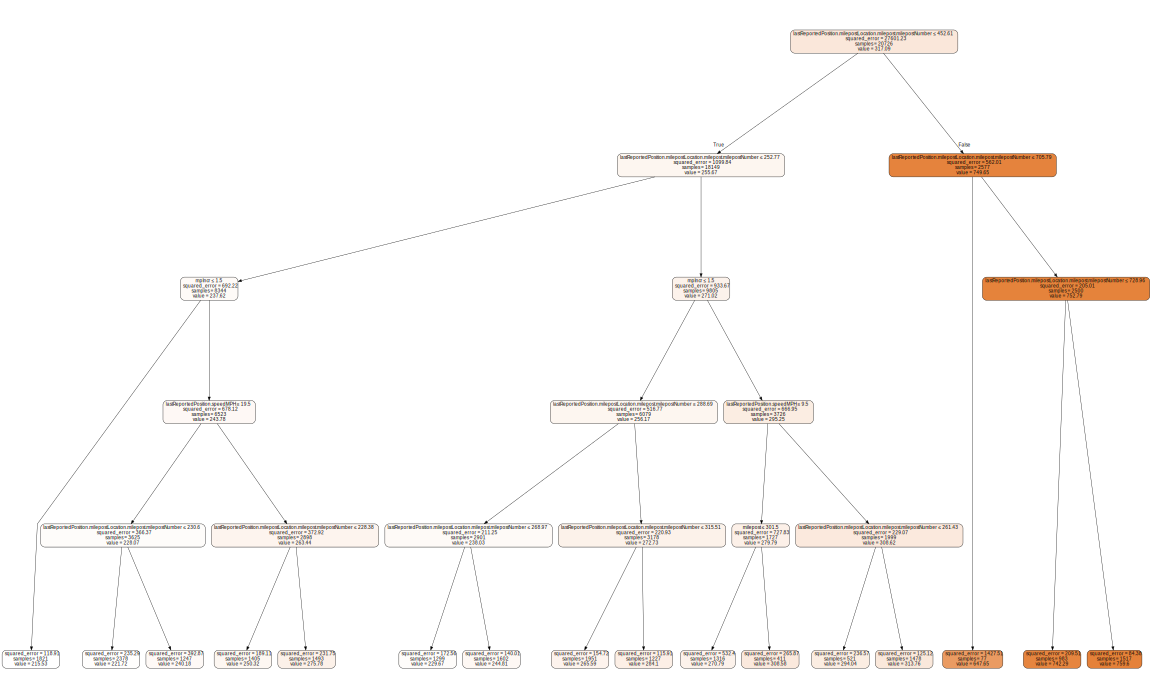

In [109]:
fastai.draw_tree(m, xs, size=16, leaves_parallel=True, precision=2)

In [110]:
m = DecisionTreeRegressor(min_samples_leaf=9)
m.fit(xs, y);

In [111]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

How well we fit the traing model:

In [112]:
m_rmse(m, xs, y)

7.985232

How well we fit the Validation Model:

In [113]:
m_rmse(m, valid_xs, valid_y)

13.388843

In [114]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [115]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
38,milepost,0.966691
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.016806
12,mpIncr,0.008345
22,lastReportedPosition.speedMPH,0.005403
3,trainId.trainSymbol,0.000404
14,workLocations,0.000297
7,aotuTrainData.priorityCode,0.000162
35,emptyCarCount,0.000162
6,lastReportedPosition.milepostLocation.trackName,0.000152
42,lastReportedPosition.positionTimeDay,0.000137


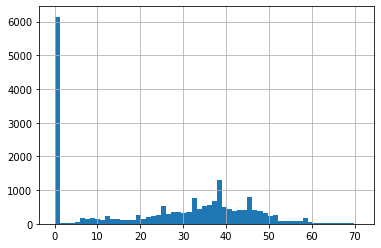

In [116]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


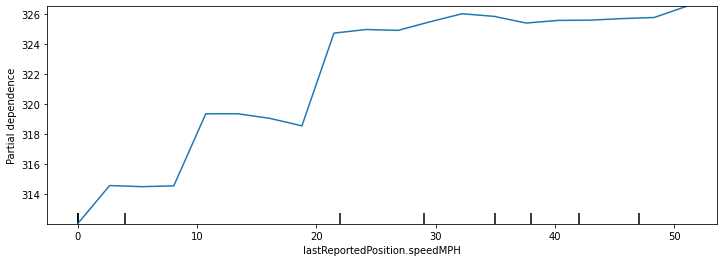

In [117]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

#Random Forest

In [118]:
def randomForest(xs, y, n_estimators=50, max_samples=2500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [119]:
m = randomForest(xs, y);

In [120]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(10.475376, 11.614412)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [122]:
r_mse(preds.mean(0), valid_y)

11.614412

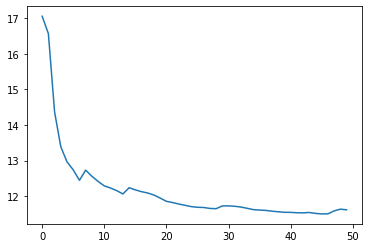

In [123]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [ ]:
r_mse(m.oob_prediction_, y)

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [126]:
preds.shape

(50, 4949)

In [127]:
preds_std = preds.std(0)

In [128]:
preds_std[:5]

array([4.80152223, 4.80152223, 4.80152223, 4.80152223, 5.14967621])

In [152]:
print(preds.mean(0)[:10])
print(valid_y[:10])

tensor([])
59       762.728699
60       762.728088
61       763.092407
62       766.728638
163      762.721802
            ...    
37986    236.349045
37987    225.254959
37988    219.881546
37989    217.072906
37990    206.479767
Name: nextValue, Length: 4939, dtype: float32


# FEATURE Importance

In [130]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
38,milepost,0.386817
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.341049
6,lastReportedPosition.milepostLocation.trackName,0.190561
14,workLocations,0.061974
12,mpIncr,0.007873
22,lastReportedPosition.speedMPH,0.004016
39,locomotiveCount,0.003594
3,trainId.trainSymbol,0.000661
25,aotuTrainData.totalCarLength,0.000286
13,symbolType,0.000277


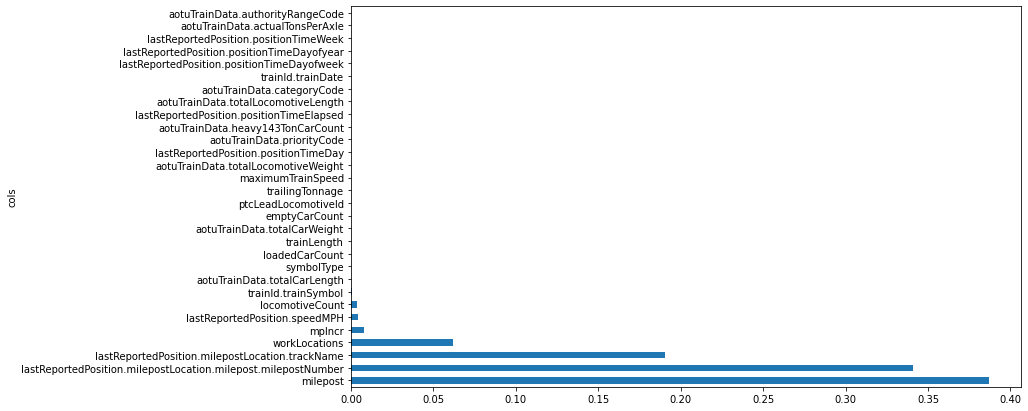

In [131]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [132]:
to_keep = fi[fi.imp>0.0002].cols
len(to_keep)

16

In [133]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [134]:
m = randomForest(xs_imp, y)

In [135]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(10.476725, 11.313404)

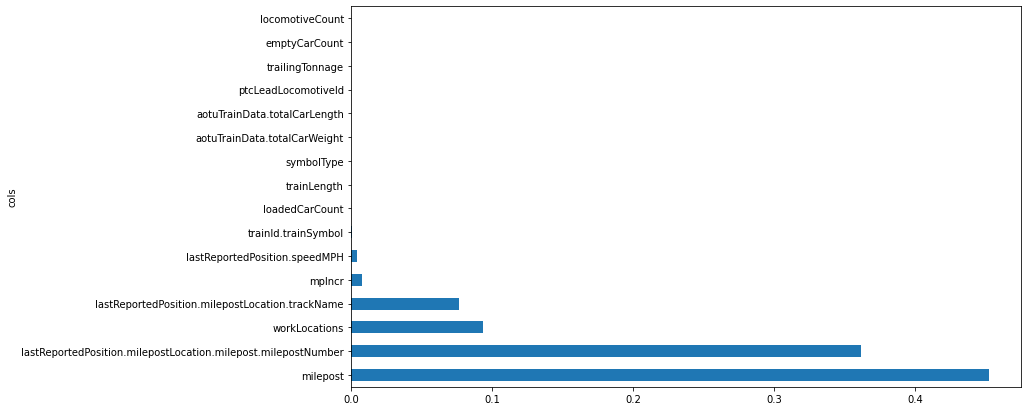

In [136]:
plot_fi(rf_feat_importance(m, xs_imp));

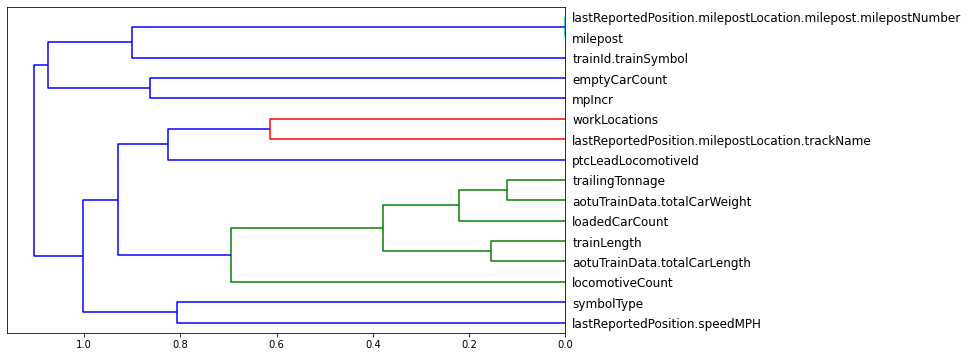

In [137]:
fastai.cluster_columns(xs_imp)

# Compute the Physics Model loss for the same interval:

In [138]:
b = dfTrainsNextBeop.tail(14165)
# beopValues = beopValues.to_frame().join(valid_y)
#m_rmse(m, valid_xs_imp, valid_y)
b = b.reset_index(drop=true)
#print (b)
y = valid_y.reset_index(drop=true)
#print (y)
df2  = pd.concat([b, y], axis=1)
df2 = df2.dropna()
print(df2)
r_mse(df2['beopValue'], df2['nextValue'])
# print(BeopValidations[:5])
#print(valid_y[:5])

      beopValue   nextValue
29    251.08168  763.099426
31    259.43170  762.739319
32    267.70798  765.718872
33    277.82004  762.737183
34    289.12732  762.737183
...         ...         ...
4937  223.15631  217.072906
4938  208.90816  206.479767
4939  200.92940  762.876770
4940  274.30475  762.481689
4941  290.27590  762.828735

[2625 rows x 2 columns]


211.304022

# Finding Out-of-Domain Data
Spot variables that are unique to the test set versus the training set

In [139]:
df_dom = pd.concat([xs, valid_xs])
is_valid = np.array([0]*len(xs) + [1]*len(valid_xs))

m = randomForest(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:8]

,cols,imp
44,lastReportedPosition.positionTimeDayofyear,0.392456
45,lastReportedPosition.positionTimeElapsed,0.363991
41,lastReportedPosition.positionTimeWeek,0.106104
4,trainId.trainDate,0.099759
40,lastReportedPosition.positionTimeMonth,0.035278
18,lastReportedPosition.positionTimeIs_quarter_end,0.001102
42,lastReportedPosition.positionTimeDay,0.001055
43,lastReportedPosition.positionTimeDayofweek,0.000254


Consider whether these values make sense

#Using a Neural Net

In [140]:
df_nn_final = dfTrainsLearn

In [141]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25675 entries, 38 to 38077
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            25675 non-null  object        
 1   trainId.trainSCAC                                              25675 non-null  category      
 2   trainId.trainSection                                           25675 non-null  category      
 3   trainId.trainSymbol                                            25675 non-null  object        
 4   trainId.trainDate                                              25675 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  25675 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            25675 non-null  int64         

In [142]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [143]:
cont_nn

['lastReportedPosition.milepostLocation.milepost.milepostNumber',
 'aotuTrainData.totalCarWeight',
 'aotuTrainData.totalCarLength',
 'aotuTrainData.totalLocomotiveWeight',
 'aotuTrainData.totalLocomotiveLength',
 'aotuTrainData.actualTonsPerAxle',
 'aotuTrainData.heavy143TonCarCount',
 'aotuTrainData.heavy158TonCarCount',
 'aotuTrainData.over158TonCarCount',
 'aotuTrainData.highWideCarCount',
 'maximumTrainSpeed',
 'loadedCarCount',
 'emptyCarCount',
 'trainLength',
 'trailingTonnage',
 'lastReportedPosition.positionTimeElapsed']

In [144]:
numUniquePerCat = df_nn_final[cat_nn].nunique()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(numUniquePerCat)

ptcLeadLocomotiveId                                    1455
trainId.trainSCAC                                         2
trainId.trainSection                                      4
trainId.trainSymbol                                     368
trainId.trainDate                                       102
lastReportedPosition.speedMPH                            72
lastReportedPosition.milepostLocation.subdivisionId       1
lastReportedPosition.milepostLocation.trackName          40
aotuTrainData.priorityCode                                5
aotuTrainData.categoryCode                               13
aotuTrainData.authorityRangeCode                          4
aotuTrainData.ownershipCode                               3
aotuTrainData.eventCode                                   1
milepost                                                248
mpIncr                                                    2
symbolType                                               14
workLocations                           

In [145]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [146]:
dls = to_nn.dataloaders(1024)

In [147]:
y = to_nn.train.y
y.min(),y.max()

(202.23622, 768.9734)

In [148]:
learn = tabular_learner(dls, y_range=(202,768), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0020892962347716093)

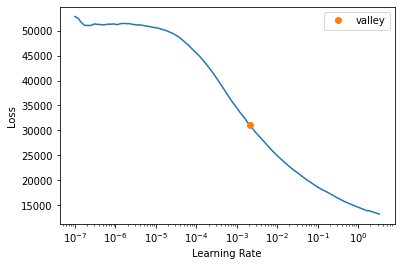

In [149]:
learn.lr_find()

In [150]:
learn.fit_one_cycle(50, 1e-2)

epoch,train_loss,valid_loss,time
0,9202.725586,37941.589844,00:01
1,5089.104492,16724.791016,00:01
2,3672.104492,1542.775757,00:01
3,2968.332031,719.777100,00:01
4,2563.721191,1704.816284,00:01
5,2345.438477,1693.297241,00:02
6,1902.221313,1401.794067,00:01
7,1485.496338,1329.829468,00:01
8,1103.538940,1272.979980,00:01
9,841.110840,1218.635742,00:01


In [153]:
preds,targs = learn.get_preds()
print(r_mse(preds,targs))
print(preds[:-10])
print(targs[:-10])

24.536398
tensor([[768.0000],
        [768.0000],
        [768.0000],
        ...,
        [227.2947],
        [220.6282],
        [214.9657]])
tensor([[762.7287],
        [762.7281],
        [763.0924],
        ...,
        [219.8815],
        [217.0729],
        [206.4798]])
